In [273]:
import operator
from collections import Counter
from scipy.stats import beta
import sys
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import math
import random
import tensorflow as tf
import scipy
import copy

%matplotlib inline

# Graphics modules
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation

In [25]:
gas_data_raw = pd.read_csv('C:/Users/hullj/Desktop/Gas Data/train2.csv')
gas_data = gas_data_raw.drop([0]).reset_index(drop=True)
desired_keys= ['DEPTH', 'C1C2FRAC', 'Comb_P_S']
df = gas_data[desired_keys]
df = df.replace(-9999.0,np.nan) # Replace null values with NaN.
df = df.rename(index=int, columns={"DEPTH": "d", "C1C2FRAC": "N", "Comb_P_S": "F"})
df.d = df.d.apply(lambda x: int(x))
df.head()

,d,N,F
0,6689,1.8943,NaN
1,6690,2.0972,NaN
2,6691,1.9410,NaN
3,6692,1.9492,NaN
4,6693,1.9583,NaN


#### Outlier detector. 

In [268]:
np.seterr(all = 'raise') # For debugging. 

# Expects depth column key and measurement column key. 
# Null values NaN.

### Utility functions ###

# In: Column data (NumPy array).
# Out: Arrays of means, standard deviations, minima, IQR in window. 
def get_local_stats(data, window_size, remove_n = None):
    # Data padded with null values for computation near ends. 
    half_window = window_size // 2
    padding = np.empty((half_window))
    padding[:] = np.nan
    padded_data = np.concatenate((padding, data, padding), axis = 0)
    # Output arrays. 
    means_array = np.empty([len(data)])
    means_array[:] = np.nan
    devs_array = np.empty([len(data)])
    devs_array[:] = np.nan
    mins_array = np.empty([len(data)])
    mins_array[:] = np.nan
    median_array = np.empty([len(data)])
    median_array[:] = np.nan
    IQR_array = np.empty([len(data)])
    IQR_array[:] = np.nan
    # Start index and default minimum gate. 
    index = half_window
    if not remove_n:
        remove_n = window_size // 10
    # Iterate.
    for i in range(len(data)):
        local_data = np.concatenate((padded_data[index-half_window : index], padded_data[index + 1 : index + half_window + 1]))
        local_data = local_data[~np.isnan(local_data)]
        if len(local_data) < half_window:
            index += 1
            continue
        local_data = np.sort(local_data)
        mins_array[i] = local_data[remove_n]
        means_array[i] = local_data.mean()
        devs_array[i] = local_data.std()
        median_array[i] = np.median(local_data)
        IQR_array[i] = scipy.stats.iqr(local_data)
        index += 1
    return means_array, devs_array, mins_array, median_array, IQR_array

# In: Column data (NumPy array).
# Out: Data scaled by first_local_mean/mean and translated to a zero minimum, array of scale factors.
def scale_and_locate(data, window_size):
    means, _, mins, _, _ = get_local_stats(data, window_size)
    smooth_mins, _, _, _, _ = get_local_stats(mins, window_size = 5)
    transformed_data = np.empty((len(data)))
    transformed_data[:] = np.nan
    inverse_scale_factors = np.empty((len(data)))
    inverse_scale_factors[:] = np.nan
    start_mean = means[~np.isnan(means)][0]
    for i in range(len(data)):
        if (not np.isnan(mins[i])) and not (np.isnan(means[i])):
            adjustment = mins[i]
            scale_factor = start_mean/means[i]
            inverse_scale_factors[i] = 1/scale_factor
            transformed_data[i] = max(scale_factor*(data[i] - adjustment), 0)
    return transformed_data, inverse_scale_factors, smooth_mins

# In: Data array.
# Out: Parameters for gamma distribution of given data.
def fit_gamma_closed_estimator(data, gamma_mode = "unbiased"):
    data = data + 1e-16 # Nudge to avoid log(0).
    N = len(data)
    data_sum = np.sum(data)
    data_log_sum = np.sum(np.log(data))
    data_log_dot = np.dot(data, np.log(data))
    k_hat = N * data_sum/(N * data_log_dot - data_log_sum * data_sum)
    theta_hat = (N * data_log_dot - data_log_sum * data_sum) / (N**2)
    if gamma_mode == 'biased':
        return k_hat, theta_hat
    else:
        k_tilde = k_hat - (3 * k_hat - (2 / 3) * (k_hat / (1 + k_hat)) - (4 / 5) * (1 / ((1 + k_hat)**2))) / N
        theta_tilde = theta_hat * N/(N - 1)
        return k_tilde, theta_tilde

# In: Gamma parameters and value.
# Out: CDF evaluated at value. 
def gamma_cdf(k, theta, x):
    return scipy.special.gammainc(k, x/theta)

# In: Column data (NumPy array).
# Out: Array giving local gamma parameters and outlier threshold. 
# Note: Threshold is .95 to declare the 5% right tail as outliers. 
def fit_gamma_along_curve(data, window_size, threshold, bisection_stop):
    half_window = window_size // 2
    padding = np.empty((half_window))
    padding[:] = np.nan
    padded_data = np.concatenate((padding, data, padding), axis = 0)
    parameter_array = np.empty([len(data), 3])
    parameter_array[:] = np.nan
    index = half_window
    b = 2
    warning = 0
    for i in range(len(data)):
        local_data = np.concatenate((padded_data[index-half_window : index], padded_data[index + 1 : index + half_window + 1]))
        local_data = local_data[~np.isnan(local_data)] ### Here's your problem.
        if len(local_data) < half_window:
            index += 1
            continue
        local_k, local_theta = fit_gamma_closed_estimator(local_data)
        ### Bisection search for critical value ###
        a = 0
        error = bisection_stop * 2
        while gamma_cdf(local_k, local_theta, b) < threshold:
            b = 2 * b
        while error > bisection_stop:
            local_critical = (a+b)/2
            cdf_value = gamma_cdf(local_k, local_theta, local_critical)
            if cdf_value > threshold:
                b = local_critical
            else:
                a = local_critical
            error = abs(cdf_value - threshold)
        ### ----------------------------------- ###
        parameter_array[i,0] = local_k
        parameter_array[i,1] = local_theta
        parameter_array[i,2] = local_critical
        index += 1
    return parameter_array

### Outlier Detector ###

class GammaOutlierDetector:
    
    def __init__(self, 
                 data, 
                 target_key, 
                 depth_key,
                 detector_mode = "continuous",
                 gamma_mode = "unbiased", 
                 window_size = 100, 
                 threshold = .95, 
                 bisection_stop = 1e-10, 
                 transform = True, 
                 supress_lower = True):
    
        self.data = copy.deepcopy(data)
        self.target_key = target_key
        self.depth_key = depth_key
        self.column = self.data[self.target_key]
        self.detector_mode = detector_mode
        self.gamma_mode = gamma_mode
        self.window_size = window_size
        self.threshold = threshold
        self.bisection_stop = bisection_stop
        self.transform = transform
        self.supress_lower = supress_lower
    
    def detect_continuous(self):
        outlier_array = np.zeros(len(self.data))
        if self.transform:
            fit_target, inverse_scale_factors, mins = scale_and_locate(self.column, window_size = self.window_size)
            parameter_array = fit_gamma_along_curve(fit_target, 
                                                    window_size = self.window_size, 
                                                    threshold = self.threshold, 
                                                    bisection_stop = self.bisection_stop)
        else:
            parameter_array = fit_gamma_along_curve(self.column, 
                                                    window_size = self.window_size, 
                                                    threshold = self.threshold, 
                                                    bisection_stop = self.bisection_stop)
        self.data[self.target_key + ' local k'] = parameter_array[:, 0]
        self.data[self.target_key + ' local theta'] = parameter_array[:, 1]
        self.data[self.target_key + ' local critical'] = parameter_array[:, 2]
        if self.transform:
            for i in range(len(inverse_scale_factors)):
                self.data[self.target_key + ' local critical'][i] = self.data[self.target_key + ' local critical'][i] * inverse_scale_factors[i] + mins[i]
        for i in range(len(self.column)):
            if ~np.isnan(self.column[i]) and self.column[i] > self.data[self.target_key + ' local critical'][i]:
                outlier_array[i] = 1
        self.data[self.target_key + ' outlier'] = outlier_array
    
    def detect_discrete(self):
        minor_outlier_array = np.zeros(len(self.data))
        major_outlier_array = np.zeros(len(self.data))
        outlier_array = np.zeros(len(self.data))
        _, _, _, median, IQR = get_local_stats(self.column, window_size = self.window_size)
        self.data[self.target_key + ' ILF'] = median - 1.5 * IQR
        self.data[self.target_key + ' IUF'] = median + 1.5 * IQR
        self.data[self.target_key + ' OLF'] = median - 3 * IQR
        self.data[self.target_key + ' OUF'] = median + 3 * IQR
        for i in range(len(self.column)):
            if np.isnan(self.column[i]):
                continue
            if self.column[i] < self.data[self.target_key + ' ILF'][i] or self.column[i] > self.data[self.target_key + ' IUF'][i]:
                minor_outlier_array[i] = 1
            if self.column[i] < self.data[self.target_key + ' OLF'][i] or self.column[i] > self.data[self.target_key + ' OUF'][i]:
                major_outlier_array[i] = 1
        for i in range(len(self.column)):
            if major_outlier_array[i] == 1:
                minor_outlier_array[i] = 0
        outlier_array = minor_outlier_array + major_outlier_array
        self.data[self.target_key + ' minor outlier'] = minor_outlier_array
        self.data[self.target_key + ' major outlier'] = major_outlier_array
        self.data[self.target_key + ' outlier'] = outlier_array
            
        
    def detect(self):
        if self.detector_mode == "discrete":
            self.detect_discrete()
        else:
            self.detect_continuous()
            
    def display(self):
        if self.detector_mode == "discrete":
            X = self.data[self.depth_key]
            minor_outliers_X = self.data[self.depth_key].loc[self.data[self.target_key + ' minor outlier'] == 1]
            minor_outliers = self.data[self.target_key].loc[self.data[self.target_key + ' minor outlier'] == 1]
            major_outliers_X = self.data[self.depth_key].loc[self.data[self.target_key + ' major outlier'] == 1]
            major_outliers = self.data[self.target_key].loc[self.data[self.target_key + ' major outlier'] == 1]
            nonoutliers_X = self.data[self.depth_key].loc[self.data[self.target_key + ' outlier'] == 0]
            nonoutliers = self.data[self.target_key].loc[self.data[self.target_key + ' outlier'] == 0]
            if not self.supress_lower:
                ILF = self.data[self.target_key + ' ILF']
                OLF = self.data[self.target_key + ' OLF']
            IUF = self.data[self.target_key + ' IUF']
            OUF = self.data[self.target_key + ' OUF']
            plt.figure(figsize=(20,10))
            plt.plot(nonoutliers_X, nonoutliers, '.', color = 'b', label = 'non-outliers')
            plt.plot(minor_outliers_X, minor_outliers, '.', color = 'y', label = 'minor outliers')
            plt.plot(major_outliers_X, major_outliers, '.', color = 'r', label = 'major outliers')
            if not self.supress_lower:
                plt.plot(X, ILF, color = 'm', label = 'inner lower fence')
                plt.plot(X, OLF, color = 'g', label = 'outer lower fence')
            plt.plot(X, IUF, color = 'm', label = 'inner upper fence')
            plt.plot(X, OUF, color = 'g', label = 'outer upper fence')
            plt.legend()
            plt.show()
        else:
            X = self.data[self.depth_key]
            outlier_X = self.data[self.depth_key].loc[self.data[self.target_key + ' outlier'] == 1]
            nonoutlier_X = self.data[self.depth_key].loc[self.data[self.target_key + ' outlier'] == 0]
            outliers = self.column.loc[self.data[self.target_key + ' outlier'] == 1]
            non_outliers = self.column.loc[self.data[self.target_key + ' outlier'] == 0]
            local_critical = self.data[self.target_key + ' local critical']
            plt.figure(figsize=(20,10))
            plt.plot(nonoutlier_X, non_outliers, '.', color = 'b', label = 'non-outliers')
            plt.plot(outlier_X, outliers, '.', color = 'r', label = 'outliers')
            plt.plot(X, local_critical, '-', color = 'g', label = 'threshold')
            plt.legend()
            plt.show()
            
    def detect_and_display(self):
        self.detect()
        self.display()
    
    def get_outlier_depths(self):
        return np.sort(self.data.loc[self.data[self.target_key + ' outlier'] == 1][self.depth_key].values)
    
    def get_minor_outlier_depths(self):
        assert self.detector_mode == 'discrete', 'Minor outlier detection only defined in discrete mode.'
        return np.sort(self.data.loc[self.data[self.target_key + ' minor outlier'] == 1][self.depth_key].values)
    
    def get_major_outlier_depths(self):
        assert self.detector_mode == 'discrete', 'Minor outlier detection only defined in discrete mode.'
        return np.sort(self.data.loc[self.data[self.target_key + ' major outlier'] == 1][self.depth_key].values)
    
    def report_outlier_depths(self):
        if self.detector_mode == 'continuous':
            depths = self.get_outlier_depths()
            print("%d outliers"%len(depths), end = " ")
            if len(depths) > 0:
                print("(depths): ", end = " ")
                for i in range(len(depths) - 1):
                    print(depths[i], end = ", ")
                print(depths[-1])
        else:
            minor_depths = self.get_minor_outlier_depths()
            print("%d minor outliers"%len(minor_depths), end = "")
            if len(minor_depths) > 0:
                print(" (depths): ", end = " ")
                for i in range(len(minor_depths) - 1):
                    print(minor_depths[i], end = ", ")
                print(minor_depths[-1], end = "\n\n")
            else:
                print(".")
            major_depths = self.get_major_outlier_depths()
            print("%d major outliers"%len(major_depths), end = "")
            if len(major_depths) > 0:
                print(" (depths): ", end = " ")
                for i in range(len(major_depths) - 1):
                    print(major_depths[i], end = ", ")
                print(major_depths[-1], end = "\n\n")
            else:
                print(".")
        
    def clean(self):
        for i in range(len(self.data)):
            if self.data[self.target_key + ' outlier'][i] == 1:
                self.data[self.target_key][i] = np.nan

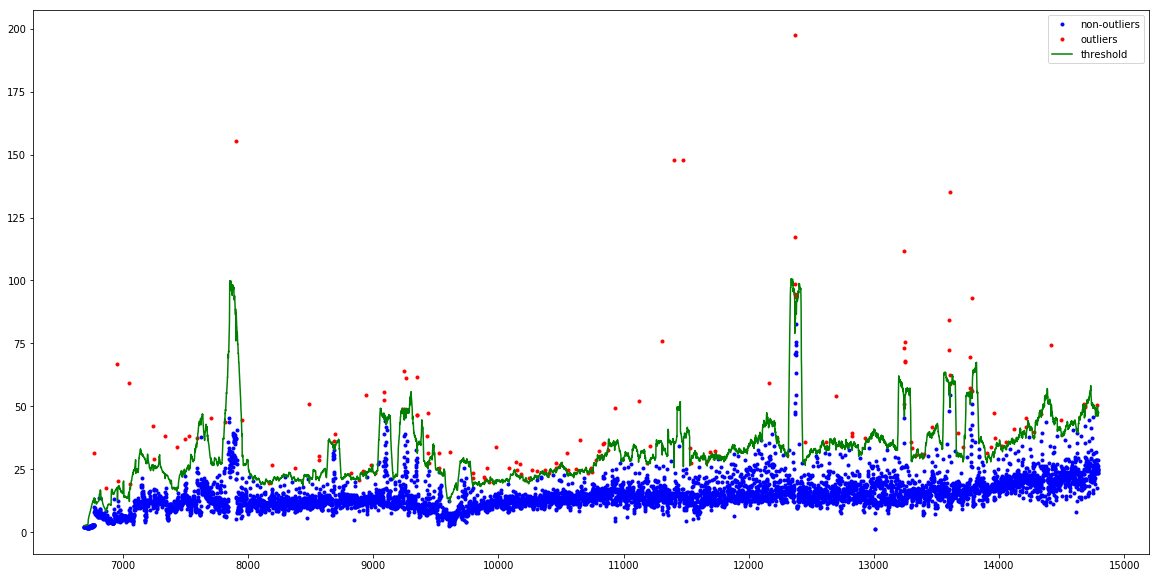

153 Outliers (depth): 6772, 6867, 6956, 6957, 7051, 7059, 7243, 7246, 7337, 7432, 7493, 7526, 7588, 7705, 7814, 7902, 7950, 8164, 8188, 8376, 8490, 8567, 8568, 8684, 8692, 8824, 8888, 8920, 8945, 8983, 9014, 9088, 9089, 9245, 9249, 9261, 9348, 9349, 9352, 9431, 9435, 9436, 9443, 9524, 9526, 9613, 9795, 9797, 9888, 9895, 9910, 9926, 9958, 9983, 10086, 10144, 10147, 10171, 10179, 10211, 10242, 10267, 10307, 10370, 10402, 10458, 10464, 10491, 10550, 10557, 10621, 10654, 10717, 10742, 10749, 10780, 10807, 10809, 10834, 10841, 10873, 10929, 11120, 11185, 11214, 11309, 11404, 11478, 11529, 11537, 11632, 11668, 11689, 11728, 11760, 12159, 12229, 12261, 12304, 12369, 12370, 12372, 12373, 12381, 12452, 12621, 12697, 12736, 12825, 12828, 12931, 13240, 13244, 13245, 13246, 13247, 13248, 13297, 13304, 13335, 13367, 13392, 13399, 13462, 13601, 13603, 13605, 13606, 13608, 13675, 13713, 13771, 13772, 13773, 13782, 13786, 13902, 13934, 13958, 13965, 14028, 14053, 14111, 14123, 14215, 14217, 14280, 143

In [238]:
continuous_detector = GammaOutlierDetector(df, 'N', 'd', threshold = .95)
continuous_detector.detect_and_display()
continuous_detector.report_outlier_depths()

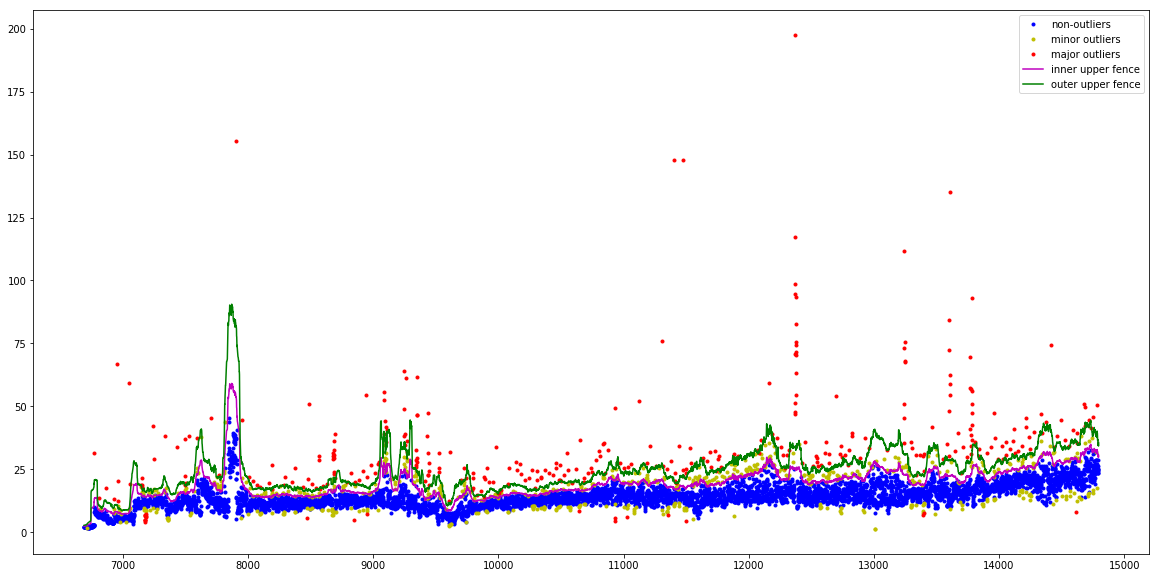

625 minor outliers (depths):  6709, 6813, 6814, 6927, 6928, 6958, 6961, 6973, 6975, 6976, 6986, 7028, 7052, 7053, 7147, 7152, 7154, 7155, 7157, 7159, 7161, 7163, 7171, 7172, 7173, 7185, 7188, 7210, 7211, 7212, 7213, 7236, 7244, 7245, 7249, 7250, 7264, 7265, 7272, 7281, 7339, 7341, 7355, 7356, 7357, 7358, 7359, 7360, 7438, 7496, 7497, 7502, 7539, 7540, 7565, 7590, 7591, 7592, 7596, 7623, 7725, 7749, 7750, 7751, 7753, 7776, 7777, 7779, 7780, 7782, 7805, 7807, 7814, 7947, 7949, 7987, 8000, 8014, 8038, 8071, 8074, 8097, 8098, 8099, 8101, 8127, 8132, 8133, 8183, 8185, 8187, 8189, 8191, 8192, 8193, 8224, 8235, 8256, 8277, 8281, 8282, 8283, 8285, 8290, 8319, 8374, 8377, 8378, 8383, 8406, 8408, 8415, 8446, 8472, 8474, 8487, 8497, 8508, 8510, 8513, 8531, 8565, 8566, 8569, 8570, 8587, 8588, 8589, 8603, 8636, 8666, 8668, 8670, 8672, 8673, 8674, 8675, 8676, 8680, 8681, 8688, 8689, 8695, 8699, 8753, 8755, 8760, 8761, 8772, 8826, 8856, 8890, 8919, 8922, 8947, 8953, 8962, 8963, 8973, 9015, 9022, 9040

In [269]:
discrete_detector = GammaOutlierDetector(df, 'N', 'd', detector_mode = 'discrete')
discrete_detector.detect_and_display()
discrete_detector.report_outlier_depths()

In [270]:
discrete_detector.clean()

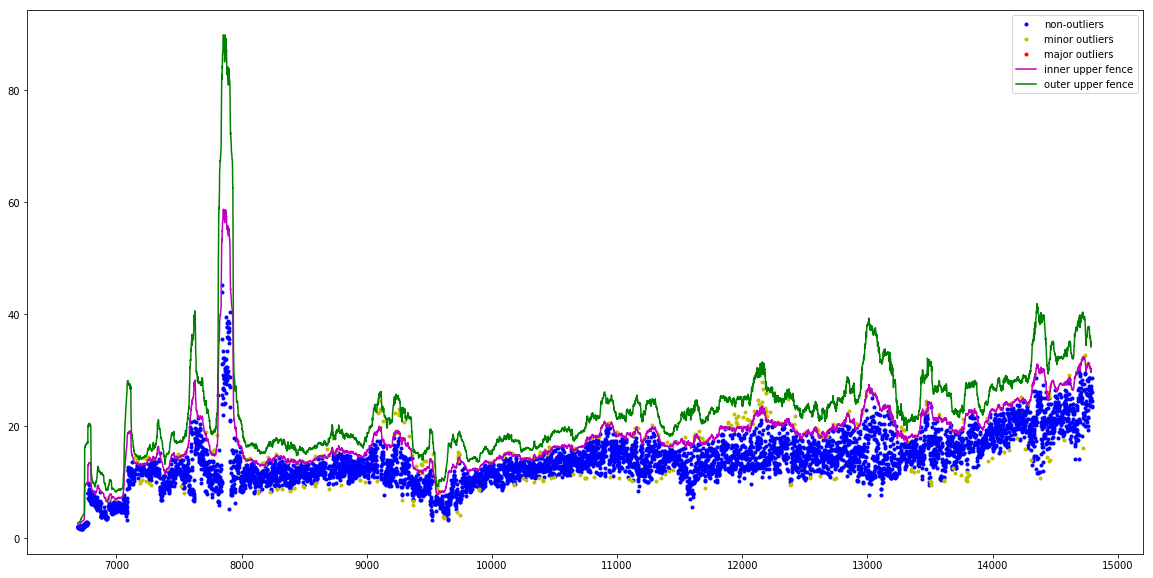

356 minor outliers (depths):  6929, 6930, 6931, 6932, 6935, 6995, 7151, 7160, 7162, 7165, 7184, 7187, 7201, 7218, 7239, 7247, 7253, 7254, 7258, 7274, 7291, 7292, 7298, 7407, 7472, 7490, 7498, 7500, 7503, 7504, 7515, 7538, 7719, 7752, 7778, 7781, 7806, 7973, 8012, 8043, 8044, 8070, 8130, 8134, 8165, 8171, 8174, 8179, 8181, 8186, 8207, 8226, 8278, 8284, 8286, 8322, 8363, 8382, 8387, 8405, 8416, 8417, 8439, 8444, 8449, 8494, 8495, 8501, 8580, 8583, 8586, 8590, 8592, 8633, 8647, 8679, 8696, 8698, 8729, 8751, 8752, 8794, 8948, 8949, 8985, 9079, 9087, 9095, 9104, 9106, 9108, 9133, 9214, 9228, 9234, 9254, 9256, 9258, 9260, 9280, 9298, 9340, 9361, 9368, 9370, 9392, 9414, 9415, 9434, 9441, 9444, 9455, 9476, 9527, 9528, 9529, 9550, 9561, 9562, 9563, 9564, 9565, 9581, 9609, 9615, 9620, 9723, 9725, 9726, 9730, 9732, 9734, 9735, 9738, 9740, 9743, 9820, 9896, 9897, 9977, 10014, 10053, 10063, 10089, 10137, 10161, 10176, 10177, 10245, 10271, 10292, 10333, 10335, 10339, 10373, 10375, 10380, 10385, 1040

In [271]:
new_data = discrete_detector.data
new_discrete_detector = GammaOutlierDetector(new_data, 'N', 'd', detector_mode = 'discrete')
new_discrete_detector.detect_and_display()
new_discrete_detector.report_outlier_depths()

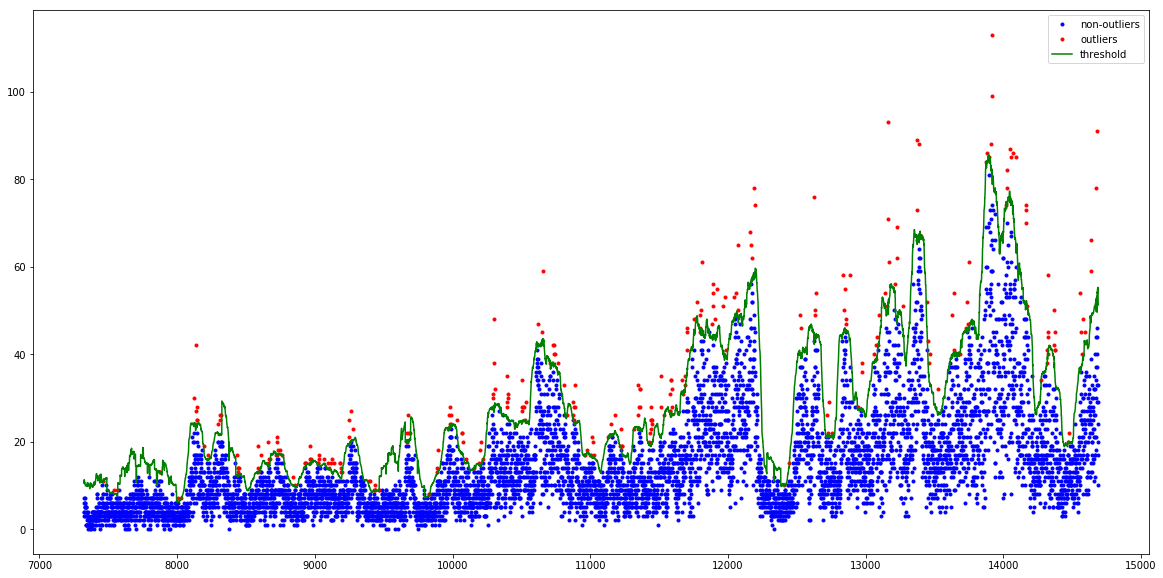

KeyError: 'F outlier'

In [231]:
continuous_detector = GammaOutlierDetector(df, 'F', 'd', threshold = .95, transform = False)
discrete_detector = GammaOutlierDetector(df, 'F', 'd', detector_mode = 'discrete')
continuous_detector.detect_and_display()
discrete_detector.report_outlier_depths()

In [197]:
detector.detect()

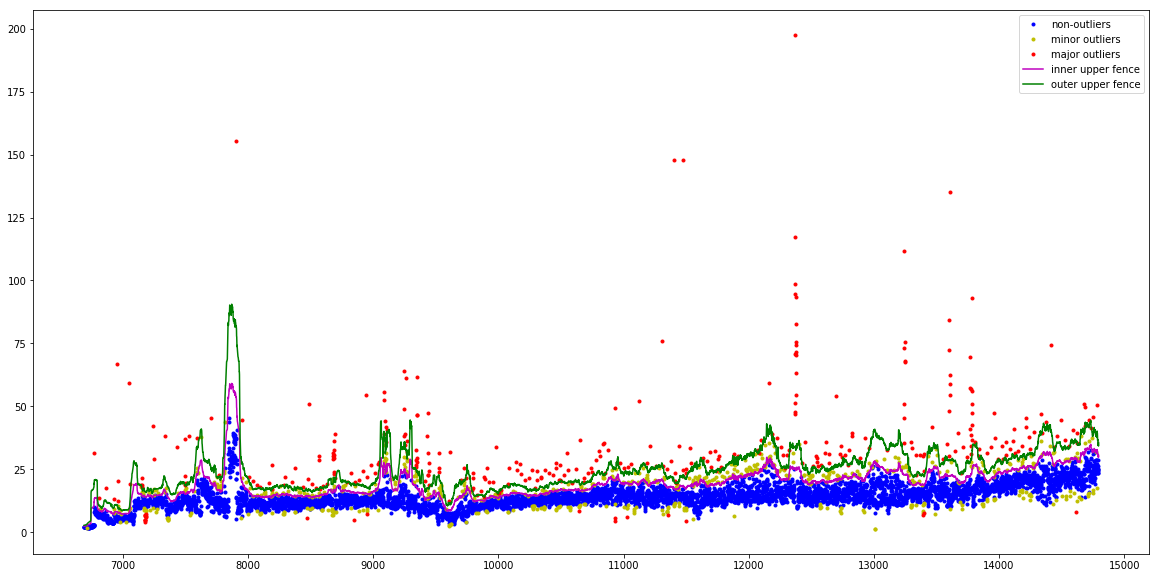

In [198]:
detector.report()

In [47]:
detector.data.loc[~np.isnan(detector.data['F'])]

,d,N,F,F local k,F local theta,F local critical,F continuous outlier
634,7323,12.2469,3.0,NaN,NaN,NaN,0.0
635,7324,12.0844,6.0,NaN,NaN,NaN,0.0
636,7325,11.6188,4.0,NaN,NaN,NaN,0.0
637,7326,11.6267,4.0,NaN,NaN,NaN,0.0
638,7327,12.1421,7.0,NaN,NaN,NaN,0.0
639,7328,11.1813,7.0,NaN,NaN,NaN,0.0
640,7329,11.0579,5.0,NaN,NaN,NaN,0.0
641,7330,11.1823,6.0,NaN,NaN,NaN,0.0
642,7331,11.7470,5.0,NaN,NaN,NaN,0.0
643,7332,11.6511,6.0,NaN,NaN,NaN,0.0


A utility plotting function. 

In [3]:
def comparison_plot(dataframe, 
                    xkey = None, 
                    ykeys = None, 
                    xlabel = False, 
                    ylabel = False, 
                    margin = False, 
                    legend = True,
                    color = 0, 
                    mode = 'line'):
    assert isinstance(xkey, str), "You must specify an x key."
    if isinstance(ykeys, str):
        assert ykeys in list(dataframe.keys()), "You must choose a key from the dataframe. Execute dataframe.keys() for options."
        ykeys = [ykeys]
    assert isinstance(ykeys, list), "The y key must be a list of keys."
    if not xlabel:
        xlabel = xkey
    if not ylabel:
        ylabel = ''
        for i in range(len(ykeys)-1):
            ylabel += str(ykeys[i]) + ', '
        ylabel += str(ykeys[-1])
    x_min = np.nanmin(dataframe[xkey].values)
    x_max = np.nanmax(dataframe[xkey].values)
    plot_min = min(0, np.nanmin(dataframe[ykeys].values))
    plot_max = np.nanmax(dataframe[ykeys].values)
    if not margin:
        margin = abs(plot_max - plot_min)/30
    if color == 'random':
        color = random.randint(0,6)
    else:
        assert isinstance(color, int), "Color must be an integer value or 'random'."
    colors = ['r','g','b','c','m','y','k']
    color = color % len(colors)
    if mode == 'points':
        for ykey in ykeys:
            plt.plot(dataframe[xkey], dataframe[ykey], '.', color = colors[color], label = ykey)
            color = (color + 1) % len(colors)
    else:
        for ykey in ykeys:
            plt.plot(dataframe[xkey], dataframe[ykey], color = colors[color], label = ykey)
            color = (color + 1) % len(colors)
    plt.axis([x_min, x_max, plot_min - margin, plot_max + margin])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend()
    plt.show()

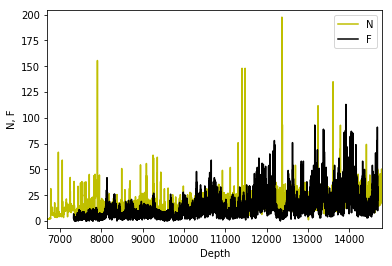

In [4]:
comparison_plot(df, xkey = 'd', xlabel = 'Depth', ykeys = ['N','F'], color = 'random')

In [5]:
# Right differential with respect to depth.
# Think about whether or not this matters right or left.

def add_column_diff(df, xkey, column_keys):
    for key in column_keys:
        print("Differentiating %s with respect to %s."%(key,xkey))
        diff_key = "d/dx(%s)"%key
        df[diff_key] = np.nan
        search_df = df.loc[df[key].notnull()]
        nonempty_index = search_df.index.values
        for i in nonempty_index:
            if i+1 in nonempty_index:
                df[diff_key][i] = (df[key][i+1]-df[key][i])/(df[xkey][i+1]-df[xkey][i])
    return df

df = add_column_diff(df,'d',['N','F'])

Differentiating N with respect to d.
Differentiating F with respect to d.


RuntimeError: Requested MovieWriter (ffmpeg) not available

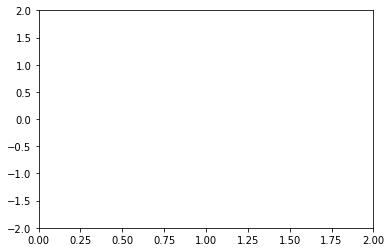

In [277]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, 
                               blit=True)

HTML(anim.to_html5_video())

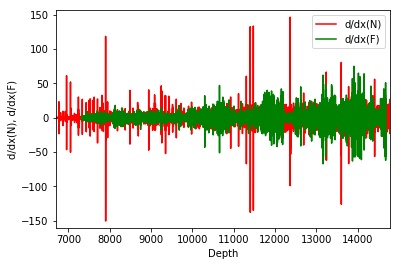

In [6]:
comparison_plot(df, xkey = 'd', xlabel = 'Depth', ykeys = ['d/dx(N)','d/dx(F)'])

In [7]:
def normalizeSeries(df,keys):
    for key in keys:
        name = 'norm%s'%key
        stddev = df[key].std()
        df[name] = np.nan
        search_df1 = df.loc[df[key].notnull()]
        search_df2 = search_df1.loc[df[key].notnull()]
        nonempty_index = search_df2.index.values
        for i in nonempty_index:
            df[name][i] = df[key][i]/stddev
    return df

df = normalizeSeries(df, ['N','F','d/dx(N)','d/dx(F)'])

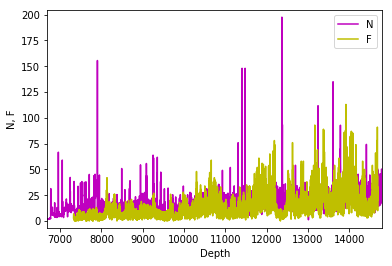

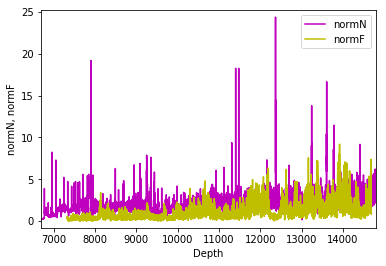

In [8]:
comparison_plot(df, xkey = 'd', xlabel = 'Depth', ykeys = ['N','F'], color = 'random')
comparison_plot(df, xkey = 'd', xlabel = 'Depth', ykeys = ['normN','normF'], color = 'random')

## Derivative Correlation:

We want to have some measure $c$ of when the variables $N$ and $F$ are changing together.  A reasonable measure of this would be given by assigning a numerical value reflecting the difference of their derivatives with respect to depth. The number should be close to 1 if the variables are moving together and close to 0 if they are moving in opposite directions or in the same direction but at disparate rates. One option: $$ c = \frac{1}{|\frac{d}{dx}N - \frac{d}{dx}F|+ 1} $$ which is 1 when the derivatives are the same and gets smaller as the derivatives differ. First, some basic statistics on how often we expect the variables to move in the same direction. 

In [9]:
df = add_column_diff(df,'d',['normN','normF'])

Differentiating normN with respect to d.
Differentiating normF with respect to d.


In [10]:
def agreement(df, epsilon = .1):
    df['agreement'] = np.nan
    search_df1 = df.loc[df['d/dx(N)'].notnull()]
    search_df2 = search_df1.loc[df['d/dx(F)'].notnull()]
    nonempty_index = search_df2.index.values
    for i in nonempty_index:
        if (df['d/dx(N)'][i] < -epsilon and df['d/dx(F)'][i] > epsilon) or (df['d/dx(N)'][i] > epsilon and df['d/dx(F)'][i] < -epsilon): 
            df['agreement'][i] = 0
        else:
            df['agreement'][i] = 1
    percent_agree = df['agreement'].sum()/len(nonempty_index) * 100
    print("In agreement %.f%% of the time"% percent_agree)
    return df

df = agreement(df)

def norm_agreement(df, epsilon = .1):
    df['norm_agreement'] = np.nan
    search_df1 = df.loc[df['d/dx(normN)'].notnull()]
    search_df2 = search_df1.loc[df['d/dx(normF)'].notnull()]
    nonempty_index = search_df2.index.values
    for i in nonempty_index:
        if (df['d/dx(normN)'][i] < -epsilon and df['d/dx(normF)'][i] > epsilon) or (df['d/dx(normN)'][i] > epsilon and df['d/dx(normF)'][i] < -epsilon): 
            df['norm_agreement'][i] = 0
        else:
            df['norm_agreement'][i] = 1
    percent_agree = df['norm_agreement'].sum()/len(nonempty_index) * 100
    print("In normal agreement %.f%% of the time"% percent_agree)
    return df

df = norm_agreement(df)

In agreement 58% of the time
In normal agreement 73% of the time


In [11]:
def NFcorr(df):
    df['NFcorr'] = np.nan
    search_df1 = df.loc[df['d/dx(N)'].notnull()]
    search_df2 = search_df1.loc[df['d/dx(F)'].notnull()]
    nonempty_index = search_df2.index.values
    for i in nonempty_index:
        df['NFcorr'][i] = 1/(abs(df['d/dx(N)'][i]-df['d/dx(F)'][i])+1)
    return df

df = NFcorr(df)

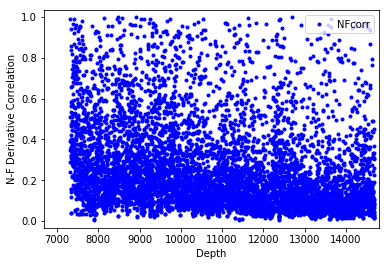

In [12]:
comparison_plot(df, xkey = 'd', xlabel = 'Depth', 
                ykeys = 'NFcorr', ylabel = 'N-F Derivative Correlation',  color = 'random', mode = 'points')

The above plot does not show much derivative correlation, but there are some obvious modifications to be made. 

In [13]:
def NFnorm_corr(df):
    df['NFnorm_corr'] = np.nan
    search_df1 = df.loc[df['d/dx(normN)'].notnull()]
    search_df2 = search_df1.loc[df['d/dx(normF)'].notnull()]
    nonempty_index = search_df2.index.values
    for i in nonempty_index:
        df['NFnorm_corr'][i] = 1/(abs(df['d/dx(normN)'][i]-df['d/dx(normF)'][i])+1)
    return df

df = NFnorm_corr(df)

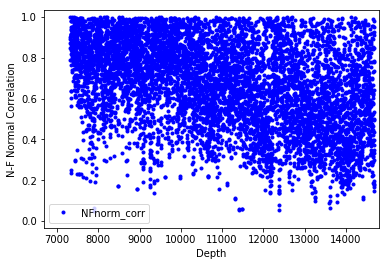

In [14]:
comparison_plot(df, xkey = 'd', xlabel = 'Depth', 
                ykeys = 'NFnorm_corr', ylabel = 'N-F Normal Correlation',  color = 'random', mode = 'points')

## Produce depths where the normal correlation is high.

Note: want to change the normalization method to reflect non-normal derivatives maybe. The derivatives are normal because the mean derivative (or the slope of the line start to finish really) is near zero.  Think about how this normalization could be more general and still pick up that case. 

In [15]:
def NFnorm_corr_high(df, parameter):
    df['NFnorm_corr_high'] = np.nan
    nonempty_index = df[df['NFnorm_corr'].gt(parameter)].index.values
    high_corr_depths = []
    for i in nonempty_index:
        df['NFnorm_corr_high'][i] = df['NFnorm_corr'][i]
        high_corr_depths.append(df['d'][i])
    return df, high_corr_depths

df, high_corr_depths = NFnorm_corr_high(df, .95)
print('High correlation at %d depths.'%len(high_corr_depths))

High correlation at 530 depths.


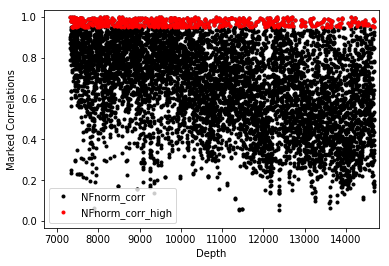

In [16]:
comparison_plot(df, xkey = 'd', xlabel = 'Depth', 
                ykeys = ['NFnorm_corr', 'NFnorm_corr_high'], ylabel = 'Marked Correlations',  color = 6, mode = 'points')

## Too many data points perhaps.

#### You should probably handle the case "increasing together substantially."

To do this; take normalized data, and at first, set a parameter for "derivative falls outside some standard deviations for both N and F, and they are both positive."

In [17]:
def NF_BT(df, parameter):
    df['NF_BT'] = np.nan
    search_df1 = df.loc[df['N'].notnull()]
    search_df2 = search_df1.loc[df['F'].notnull()]
    stdev_ddx_normN = df['N'].std()
    print(stdev_ddx_normN)
    mean_ddx_normN = df['N'].mean()
    print(mean_ddx_normN)
    N_threshold = mean_ddx_normN + parameter*stdev_ddx_normN
    stdev_ddx_normF = df['F'].std()
    print(stdev_ddx_normF)
    mean_ddx_normF = df['F'].mean()
    print(mean_ddx_normF)
    F_threshold = mean_ddx_normF + parameter*stdev_ddx_normF
    nonempty_index = search_df2.index.values
    BT_depths = []
    for i in nonempty_index:
        if df['N'][i] > N_threshold and df['F'][i] > F_threshold:
            df['NF_BT'][i] = df['N'][i]
            BT_depths.append(df['d'][i])
    return df, BT_depths

df, BT_depths = NF_BT(df, 1)
print("Found %d depths where N and F are large."%len(BT_depths))

def NF_IT(df, parameter):
    df['NF_IT'] = np.nan
    search_df1 = df.loc[df['d/dx(N)'].notnull()]
    search_df2 = search_df1.loc[df['d/dx(F)'].notnull()]
    stdev_ddx_normN = df['d/dx(N)'].std()
    print(stdev_ddx_normN)
    mean_ddx_normN = df['d/dx(N)'].mean()
    print(mean_ddx_normN)
    N_threshold = mean_ddx_normN + parameter*stdev_ddx_normN
    stdev_ddx_normF = df['d/dx(F)'].std()
    print(stdev_ddx_normF)
    mean_ddx_normF = df['d/dx(F)'].mean()
    print(mean_ddx_normF)
    F_threshold = mean_ddx_normF + parameter*stdev_ddx_normF
    nonempty_index = search_df2.index.values
    IT_depths = []
    for i in nonempty_index:
        if df['d/dx(N)'][i-1] > N_threshold and df['d/dx(F)'][i-1] > F_threshold:
            df['NF_IT'][i] = df['N'][i]
            IT_depths.append(df['d'][i])
    return df, IT_depths

df, IT_depths = NF_IT(df, 1)
print("Found %d depths where N and F both experience abnormal increase."%len(IT_depths))

8.104963751173774
15.034467460219552
12.306746560079487
14.510248405049545
Found 124 depths where N and F are large.
7.78142771718015
0.003299161115223284
9.776427291855615
0.0040727667662231876
Found 56 depths where N and F both experience abnormal increase.


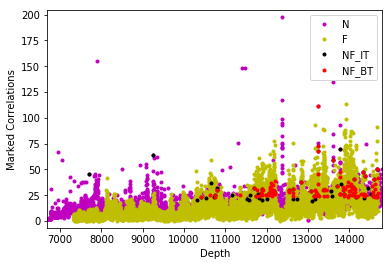

In [18]:
comparison_plot(df, xkey = 'd', xlabel = 'Depth', 
                ykeys = ['N', 'F', 'NF_IT', 'NF_BT'], ylabel = 'Marked Correlations',  color = 4, mode = 'points')

Make a window that slides along the data and takes means, standard deviations. Call it local_statistics. 

## Beta Derivative Correlation:

The difference in values of the measurements will affect the difference in distribution. We have the option to handle this by normalizing the measurements to the interval $[0,1]$.  This is the so-called beta-normalization (so termed after the beta distribution), and we can use this data for a beta derivative correlation. 

In [19]:
def betaNormalizeSeries(df,keys):
    for key in keys:
        name = 'betaNorm%s'%key
        minval = df[key].min()
        maxval = df[key].max()-minval
        df[name] = np.nan
        search_df1 = df.loc[df[key].notnull()]
        search_df2 = search_df1.loc[df[key].notnull()]
        nonempty_index = search_df2.index.values
        for i in nonempty_index:
            df[name][i] = (df[key][i]-minval)/(maxval)
    return df

df = betaNormalizeSeries(df, ['N','F'])

Unaltered Values:


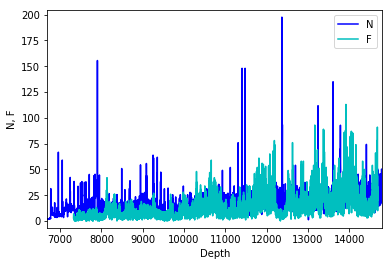

Normalized Values:


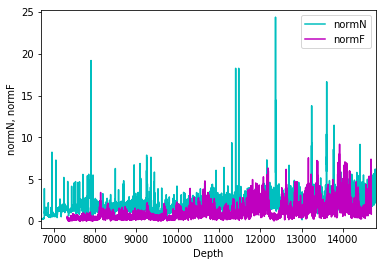

Beta-Normalized Values:


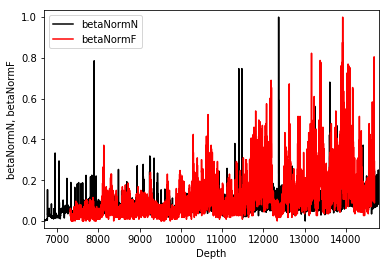

In [20]:
print('Unaltered Values:')
comparison_plot(df, xkey = 'd', xlabel = 'Depth', ykeys = ['N','F'], color = 'random')
print('Normalized Values:')
comparison_plot(df, xkey = 'd', xlabel = 'Depth', ykeys = ['normN','normF'], color = 'random')
print('Beta-Normalized Values:')
comparison_plot(df, xkey = 'd', xlabel = 'Depth', ykeys = ['betaNormN','betaNormF'], color = 'random')

In [21]:
def NFder_diff(df):
    df['NFder_diff'] = np.nan
    search_df1 = df.loc[df['d/dx(normN)'].notnull()]
    search_df2 = search_df1.loc[df['d/dx(normF)'].notnull()]
    nonempty_index = search_df2.index.values
    for i in nonempty_index:
        df['NFder_diff'][i] = abs(df['d/dx(normN)'][i]-df['d/dx(normF)'][i])
    return df

df = NFder_diff(df)

0.0004070543948756711


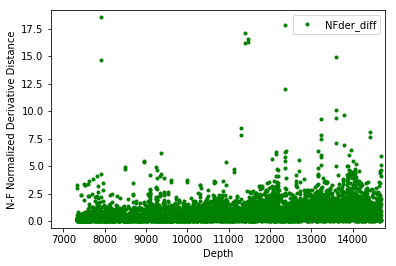

In [22]:
diff_mean = df['d/dx(normN)'].mean()
print(diff_mean)

comparison_plot(df, xkey = 'd', xlabel = 'Depth', 
                ykeys = 'NFder_diff', ylabel = 'N-F Normalized Derivative Distance',  color = 'random', mode = 'points')

In [23]:
df = add_column_diff(df,'d',['betaNormN','betaNormF'])

Differentiating betaNormN with respect to d.
Differentiating betaNormF with respect to d.


In [24]:
def NFbeta_corr(df):
    df['NFbeta_corr'] = np.nan
    search_df1 = df.loc[df['d/dx(betaNormN)'].notnull()]
    search_df2 = search_df1.loc[df['d/dx(betaNormF)'].notnull()]
    nonempty_index = search_df2.index.values
    for i in nonempty_index:
        df['NFbeta_corr'][i] = 1/(abs(df['d/dx(betaNormN)'][i]-df['d/dx(betaNormF)'][i])+1)
    return df

df = NFbeta_corr(df)

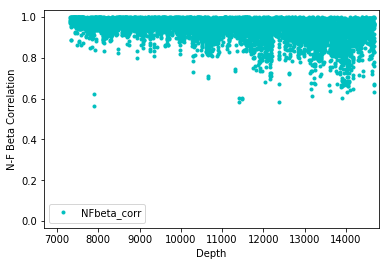

In [25]:
comparison_plot(df, xkey = 'd', xlabel = 'Depth', 
                ykeys = 'NFbeta_corr', ylabel = 'N-F Beta Correlation',  color = 'random', mode = 'points')

This shows wildly improved predicability between the change in $N$ and the change in $F$, this without even accounting for outlier data in either set, however this data transformation loses a great deal of data regarding how much each variable is changing. In fact, one could argue that we've just made the derivatives smaller, and that's what causes the clustering at the top. 

## Best-Fit Scalar

We can assume that $N$ and $F$ are scalar multiples of each other and attempt to find the scalar that best fits this hypothesis. We use an ad hoc TensorFlow method to do this minimize the mean-squared error of $N-\alpha F$ where $\alpha$ is some scalar in $\mathbb{R}$.

In [26]:
# We will only train the scalar on values where both measurements
# are non-null. 

def make_vectors(df):
    search_df1 = df.loc[df['N'].notnull()]
    search_df2 = search_df1.loc[df['F'].notnull()]
    nonempty_index = search_df2.index.values
    Nvector = df['N'][nonempty_index].values
    Fvector = df['F'][nonempty_index].values
    return Nvector, Fvector

column1, column2 = make_vectors(df)

In [27]:
scalar_fit_graph = tf.Graph()

with scalar_fit_graph.as_default():
    V1 = tf.constant(column1, dtype = tf.float32)
    V2 = tf.constant(column2, dtype = tf.float32)
    alpha = tf.Variable(1, dtype = tf.float32)
    bias = tf.Variable(tf.zeros([1]))
    # Model
    scaled_V2 = tf.math.scalar_mul(alpha, V2) 
    difference = tf.math.square(V1 - (scaled_V2 + bias))
    loss = tf.reduce_mean(difference)
    optimizer = tf.train.AdagradOptimizer(0.001).minimize(loss)

In [28]:
number_of_iterations = 500000

with tf.Session(graph = scalar_fit_graph) as session:
    tf.global_variables_initializer().run()
    print('Variables Initialized.')
    for iteration in range(number_of_iterations):
        session.run(optimizer)
    final_scalar = alpha.eval()
    final_bias = bias.eval()
    print('Final Scalar: %f' % final_scalar)
    print('Final Bias: %f' % final_bias)

Variables Initialized.
Final Scalar: 0.602387
Final Bias: 1.580602


In [29]:
df['scaleF'] = final_scalar*df['F'] + final_bias
df = add_column_diff(df,'d',['scaleF'])

def NFscalar_corr(df):
    df['NFscalar_corr'] = np.nan
    search_df1 = df.loc[df['d/dx(N)'].notnull()]
    search_df2 = search_df1.loc[df['d/dx(scaleF)'].notnull()]
    nonempty_index = search_df2.index.values
    for i in nonempty_index:
        df['NFscalar_corr'][i] = 1/(abs(df['d/dx(N)'][i]-df['d/dx(scaleF)'][i])+1)
    return df

df = NFscalar_corr(df)

Differentiating scaleF with respect to d.


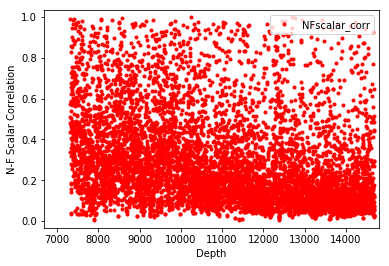

In [30]:
comparison_plot(df, xkey = 'd', xlabel = 'Depth', 
                ykeys = 'NFscalar_corr', ylabel = 'N-F Scalar Correlation',  color = 'random', mode = 'points')

Not very positive results, similar to the first attempt. 

## Generating Synthetic Gas Data

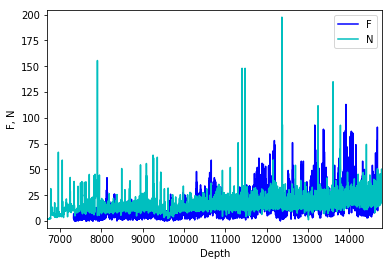

In [31]:
comparison_plot(df, xkey = 'd', xlabel = 'Depth', ykeys = ['F', 'N'], color = 'random')

In [32]:
df.head()

,d,N,F,d/dx(N),d/dx(F),normN,normF,normd/dx(N),normd/dx(F),d/dx(normN),...,NF_IT,betaNormN,betaNormF,NFder_diff,d/dx(betaNormN),d/dx(betaNormF),NFbeta_corr,scaleF,d/dx(scaleF),NFscalar_corr
0,6689,1.8943,NaN,0.2029,NaN,0.233721,NaN,0.026075,NaN,0.025034,...,NaN,0.003541,NaN,NaN,0.001033,NaN,NaN,NaN,NaN,NaN
1,6690,2.0972,NaN,-0.1562,NaN,0.258755,NaN,-0.020073,NaN,-0.019272,...,NaN,0.004574,NaN,NaN,-0.000795,NaN,NaN,NaN,NaN,NaN
2,6691,1.9410,NaN,0.0082,NaN,0.239483,NaN,0.001054,NaN,0.001012,...,NaN,0.003779,NaN,NaN,0.000042,NaN,NaN,NaN,NaN,NaN
3,6692,1.9492,NaN,0.0091,NaN,0.240495,NaN,0.001169,NaN,0.001123,...,NaN,0.003821,NaN,NaN,0.000046,NaN,NaN,NaN,NaN,NaN
4,6693,1.9583,NaN,0.0173,NaN,0.241617,NaN,0.002223,NaN,0.002134,...,NaN,0.003867,NaN,NaN,0.000088,NaN,NaN,NaN,NaN,NaN


# Make outlier-detection class. use partitioning, a deck window

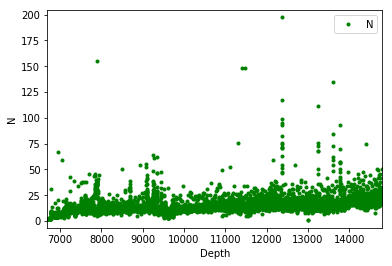

In [33]:
comparison_plot(df, xkey = 'd', xlabel = 'Depth', ykeys = ['N'], color = 'random', mode = 'points')

# Tasks:

1. Distribution fit.
    a. Fit various distributions. 
    b. Execute distribution fit tests (fit-test class for Anderson-Darling statistic, p-test, etc.).
    c. Parametrize fit along curve, i.e. sample along depth.
    d. Re-execute fit tests.
2. Define and execute outlier-detection class. 


## Fitting a parametric distribution.

### Gamma: $$\Gamma(x|k,\theta)_{\text{PDF}}=\frac{1}{\Gamma(k)\theta^{k}}x^{k-1}e^{-\frac{x}{\theta}}$$

We use the closed form estimators $$ \hat{k} = \frac{N\sum_{i=1}^{N}x_{i}}{N\sum_{i=1}^{N}x_{i}\text{ln}(x_{i})-\sum_{i=1}^{N}\text{ln}(x_{i})\sum_{i=1}^{N}x_{i}}$$

$$ \hat{\theta} = \frac{1}{N^{2}}\left(N\sum_{i=1}^{N}x_{i}\text{ln}(x_{i})-\sum_{i=1}^{N}\text{ln}(x_{i})\sum_{i=1}^{N}x_{i}\right)$$ with bias corrections $$ \tilde{\theta} = \frac{N}{N-1}\hat{\theta}$$ 

$$ \tilde{k}=\hat{k}-\frac{1}{N}\left(3\hat{k}-\frac{2}{3}\left(\frac{\hat{k}}{1+\hat{k}}\right)-\frac{4}{5}\frac{\hat{k}}{(1+\hat{k})^{2}}  \right).$$

In [1]:
if not None:
    print("True")

True


In [35]:
data = df['N'].loc[df['N'].notnull()].values
print(type(data))
print(data.shape)
X = df['d'].loc[df['N'].notnull()].values

<class 'numpy.ndarray'>
(8107,)


In [63]:
def fit_gamma_ClE(data, mode = "unbiased"):
    data = data + 1e-16
    N = len(data)
    data_sum = np.sum(data)
    data_log_sum = np.sum(np.log(data))
    data_log_dot = np.dot(data, np.log(data))
    k_hat = N * data_sum/(N * data_log_dot - data_log_sum * data_sum)
    theta_hat = (N * data_log_dot - data_log_sum * data_sum) / (N**2)
    if mode == 'biased':
        return k_hat, theta_hat
    else:
        k_tilde = k_hat - (3 * k_hat - (2 / 3) * (k_hat / (1 + k_hat)) - (4 / 5) * (1 / ((1 + k_hat)**2))) / N
        theta_tilde = theta_hat * N/(N - 1)
        return k_tilde, theta_tilde
    
k, theta = fit_gamma_ClE(data, mode = 'biased')

In [37]:
print(k)
print(theta)

4.935064600051457
3.0464580869038267


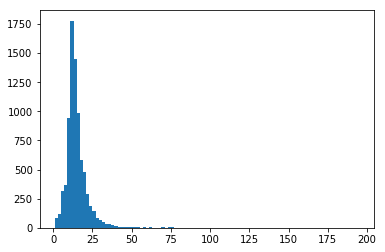

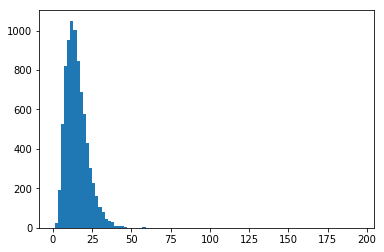

In [38]:
plt.hist(data, bins = range(int(math.floor(df['N'].min())),int(math.floor(df['N'].max())),2))
#plt.title('Random Gaussian data (fixed bin size)')
#plt.xlabel('variable X (bin size = 5)')
#plt.ylabel('count')

plt.show()

synth_data = np.random.gamma(k, theta, len(data))
plt.hist(synth_data, bins = range(int(math.floor(df['N'].min())),int(math.floor(df['N'].max())),2))
plt.show()

## Next Up: Fit along the curve. Consider local shifts and SciPy fitting.

In [39]:
data[:10]

array([1.8943, 2.0972, 1.941 , 1.9492, 1.9583, 1.9756, 2.1033, 1.9574,
       1.9601, 1.983 ])

In [40]:
window_size = 225

def get_local_means(data, window):
    half_window = window // 2
    padding = np.empty((half_window))
    padding[:] = np.nan
    padded_data = np.concatenate((padding, data, padding), axis = 0)
    means_array = np.empty([len(data)])
    means_array[:] = np.nan
    index = half_window
    for i in range(len(data)):
        local_data = padded_data[index-half_window: index + half_window + 1]
        local_data = local_data[~np.isnan(local_data)]
        local_mean = np.sum(local_data)/len(local_data)
        means_array[i] = local_mean
        index += 1
    return means_array

means = get_local_means(data, 20)

def get_local_stddevs(data, window):
    half_window = window // 2
    padding = np.empty((half_window))
    padding[:] = np.nan
    padded_data = np.concatenate((padding, data, padding), axis = 0)
    devs_array = np.empty([len(data)])
    devs_array[:] = np.nan
    index = half_window
    for i in range(len(data)):
        local_data = padded_data[index-half_window: index + half_window + 1]
        local_data = local_data[~np.isnan(local_data)]
        local_stddev = local_data.std()
        devs_array[i] = local_stddev
        index += 1
    return devs_array

std_devs = get_local_stddevs(data, 20)

def get_local_mins(data, window, remove_n = 10):
    half_window = window // 2
    padding = np.empty((half_window))
    padding[:] = np.nan
    padded_data = np.concatenate((padding, data, padding), axis = 0)
    mins_array = np.empty([len(data)])
    mins_array[:] = np.nan
    index = half_window
    for i in range(len(data)):
        local_data = np.concatenate((padded_data[index-half_window : index], padded_data[index + 1 : index + half_window + 1]))
        local_data = np.sort(local_data[~np.isnan(local_data)])
        mins_array[i] = local_data[remove_n]
        index += 1
    smooth_mins = get_local_means(mins_array, window = 5)
    return smooth_mins

mins = get_local_mins(data, window_size)

def transform_data(data, means, mins):
    transformed_data = np.empty((len(data)))
    transformed_data[:] = np.nan
    start_mean = means[0]
    for i in range(len(data)):
        adjustment = mins[i]
        scale_factor = start_mean/means[i]
        transformed_data[i] = max(scale_factor*(data[i] - adjustment), 0)
    return transformed_data

transformed_data = transform_data(data, means, mins)

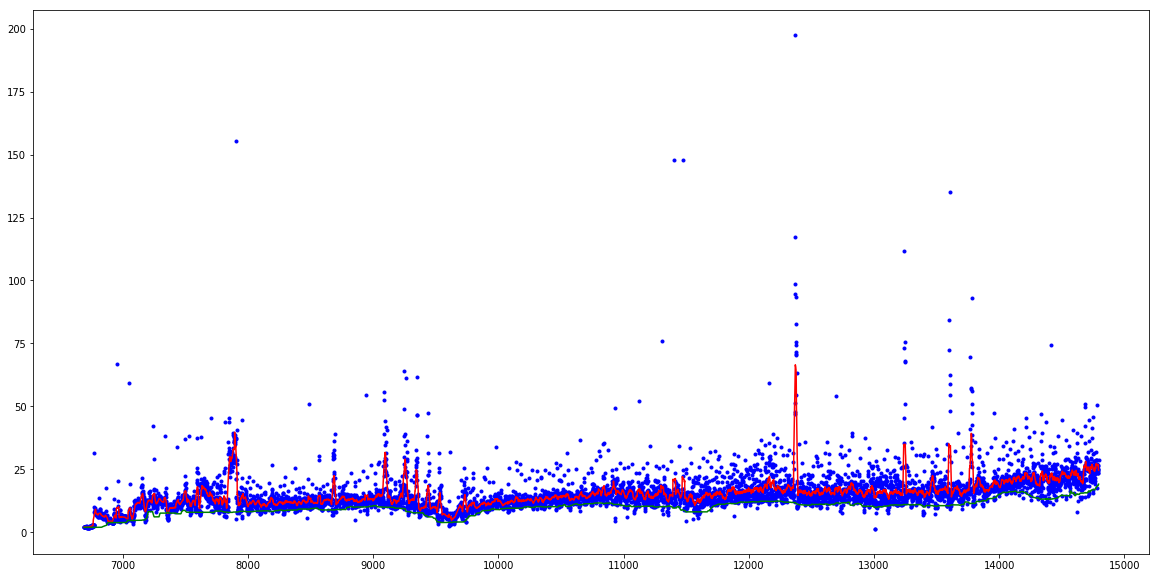

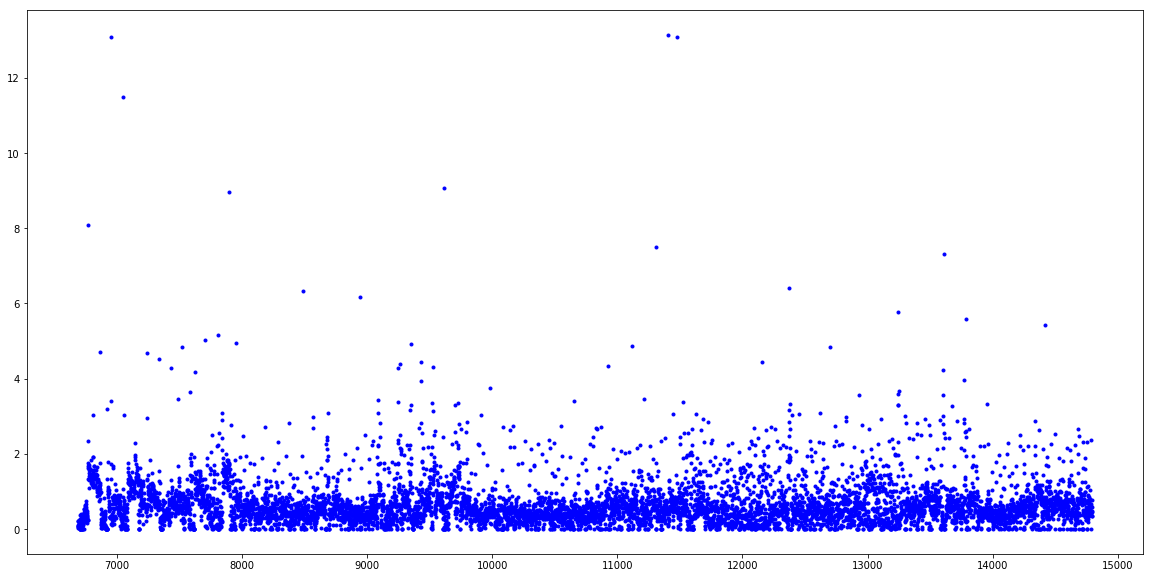

In [41]:
plt.figure(figsize=(20,10))
plt.plot(X, data, '.', color = 'b', label = 'Data')
plt.plot(X, means, color = 'r', label = 'Data')
plt.plot(X, mins, color = 'g', label = 'Data')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(X, transformed_data, '.', color = 'b', label = 'Data')

In [60]:
a = .023e-10
print(a)

2.3e-12


In [82]:
def gamma_cdf(k, theta, x):
    return scipy.special.gammainc(k, x/theta) 

local_k = 1
local_theta = 2

for i in range(8):
    print(gamma_cdf(local_k,local_theta,i))
    
 ### Bisection search for critical value ###
bisection_stop = .001
threshold = .95
b = 2
a = 0
error = bisection_stop * 2
while gamma_cdf(local_k, local_theta, b) < threshold:
    b = 2 * b
print('bisection start')
while error > bisection_stop:
    local_critical = (a+b)/2
    cdf_value = gamma_cdf(local_k, local_theta, local_critical)
    print(cdf_value)
    if cdf_value > threshold:
        b = local_critical
    else:
        a = local_critical
    error = abs(cdf_value - threshold)
    print(error)
    print("cdf: "+str(cdf_value))
    print("crit: "+str(local_critical))
print('bisection complete')

0.0
0.3934693402873665
0.6321205588285577
0.7768698398515702
0.8646647167633873
0.9179150013761012
0.950212931632136
0.9698026165776815
bisection start
0.8646647167633873
0.08533528323661266
cdf: 0.8646647167633873
crit: 4.0
0.950212931632136
0.000212931632136093
cdf: 0.950212931632136
crit: 6.0
bisection complete


In [5]:
if not None:
    print("Yowzas!")

Yowzas!


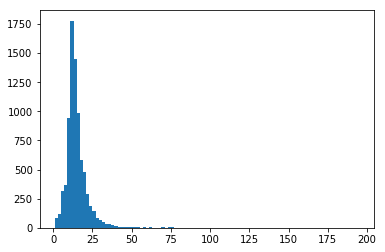

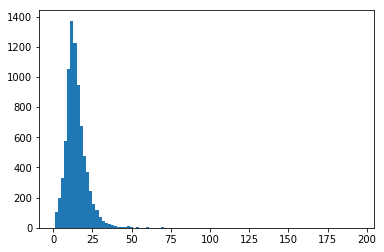

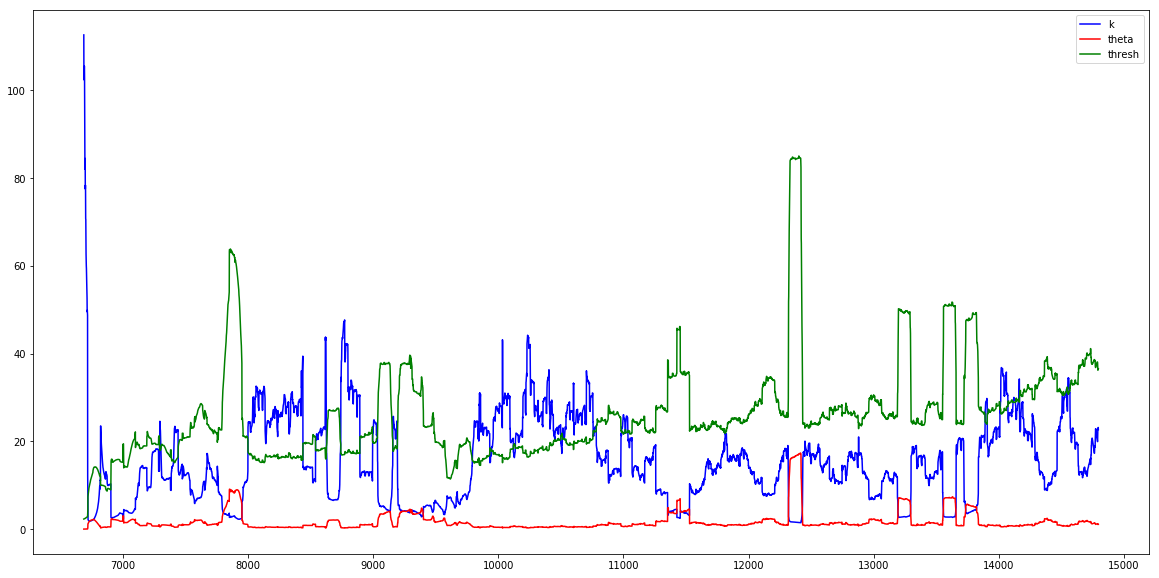

In [94]:
# Fix to handle general null exceptions. Important.
def gamma_cdf(k, theta, x):
    return scipy.special.gammainc(k, x/theta) 

def fit_gamma_along_curve(data, window = 100, threshold = .98, bisection_stop = 1e-10):
    half_window = window // 2
    padding = np.empty((half_window))
    padding[:] = np.nan
    padded_data = np.concatenate((padding, data, padding), axis = 0)
    parameter_array = np.empty([len(data), 3])
    parameter_array[:] = np.nan
    index = half_window
    b = 2
    for i in range(len(data)):
        local_data = padded_data[index-half_window: index + half_window + 1]
        local_data = local_data[~np.isnan(local_data)]
        local_k, local_theta = fit_gamma_ClE(local_data)
        ### Bisection search for critical value ###
        a = 0
        error = bisection_stop * 2
        while gamma_cdf(local_k, local_theta, b) < threshold:
            b = 2 * b
        while error > bisection_stop:
            local_critical = (a+b)/2
            cdf_value = gamma_cdf(local_k, local_theta, local_critical)
            if cdf_value > threshold:
                b = local_critical
            else:
                a = local_critical
            error = abs(cdf_value - threshold)
        ### ----------------------------------- ###
        parameter_array[i,0] = local_k
        parameter_array[i,1] = local_theta
        parameter_array[i,2] = local_critical
        index += 1
    return parameter_array

parameter_array = fit_gamma_along_curve(data, window = 100)

def generate_gamma_along_curve(paramter_array, size):
    synth_data = np.empty((len(paramter_array)))
    synth_data[:] = np.nan
    for i in range(size):
        step_shape = parameter_array[i, 0]
        step_scale = parameter_array[i, 1]
        synth_data[i] = np.random.gamma(step_shape, step_scale, 1)
    return synth_data

synth_data = generate_gamma_along_curve(parameter_array, len(data))

plt.hist(data, bins = range(int(math.floor(df['N'].min())), int(math.floor(df['N'].max())),2))
plt.show()

plt.hist(synth_data, bins = range(int(math.floor(df['N'].min())),int(math.floor(df['N'].max())),2))
plt.show()

plt.figure(figsize=(20,10))
plt.plot(X, parameter_array[:,0], color = 'b', label = 'k')
plt.plot(X, parameter_array[:,1], color = 'r', label = 'theta')
plt.plot(X, parameter_array[:,2], color = 'g', label = 'thresh')
plt.legend()
plt.show()

In [90]:
window_size = 20
t_synth = generate_gamma_along_curve(fit_gamma_along_curve(transformed_data, window_size), len(data))
shifted_t_synth = np.array([max(t_synth[i] + mins[i] + np.random.normal(0,1), 0) for i in range(len(t_synth))])

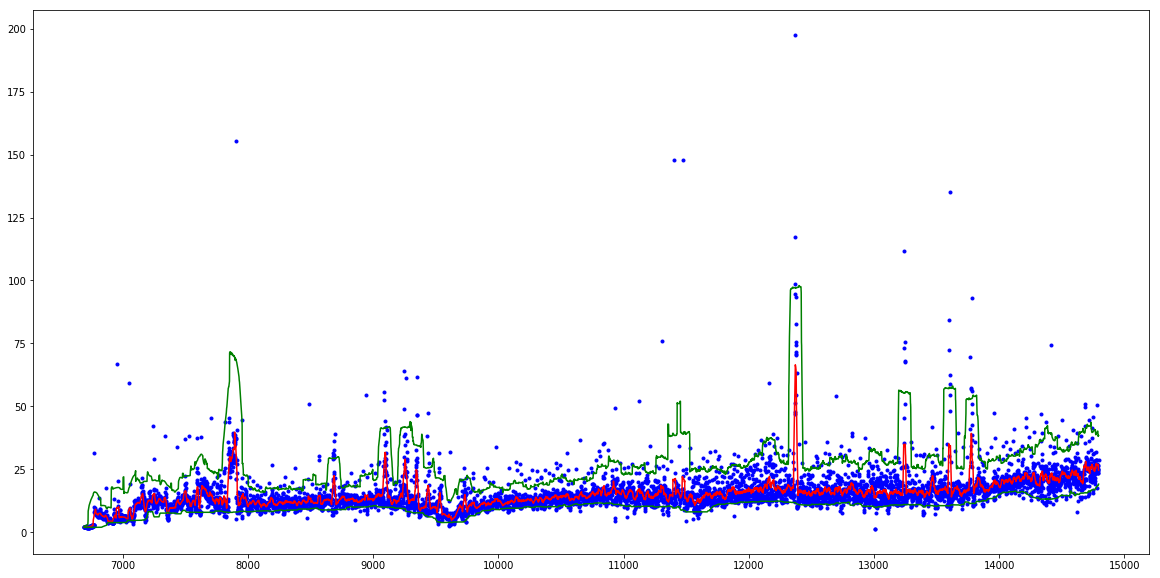

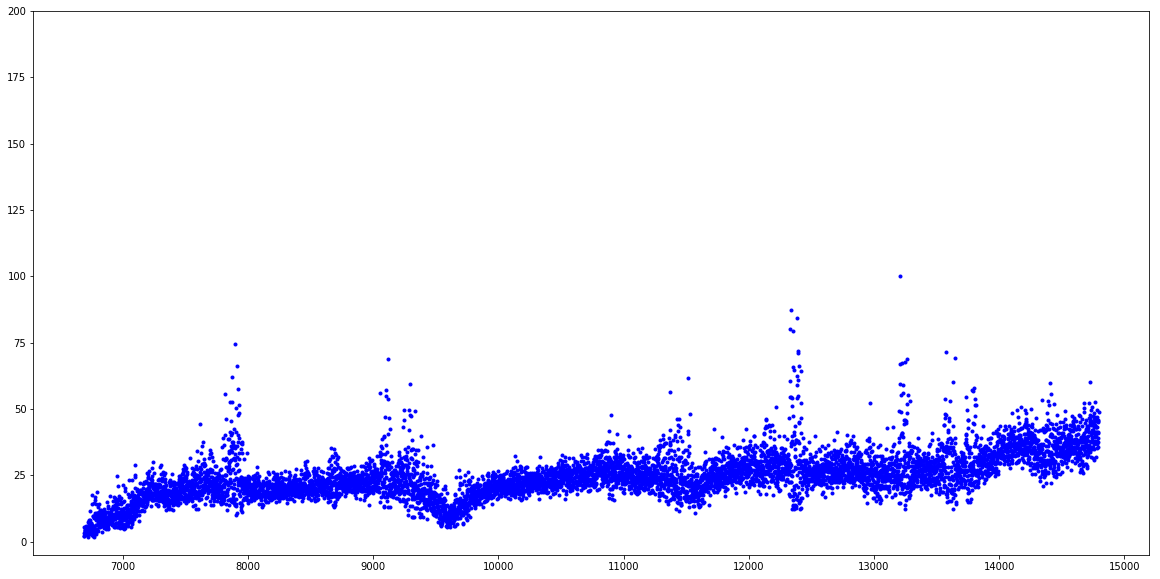

In [93]:
parameter_array = fit_gamma_along_curve(data, window = 100, threshold = .99)

plt.figure(figsize=(20,10))
plt.plot(X, data, '.', color = 'b', label = 'Data')
plt.plot(X, means, color = 'r', label = 'Data')
plt.plot(X, mins, color = 'g', label = 'Data')
plt.plot(X, parameter_array[:,2], color = 'g', label = 'thresh')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(X, shifted_t_synth, '.', color = 'b', label = 'Data')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,-5,200))
plt.show()

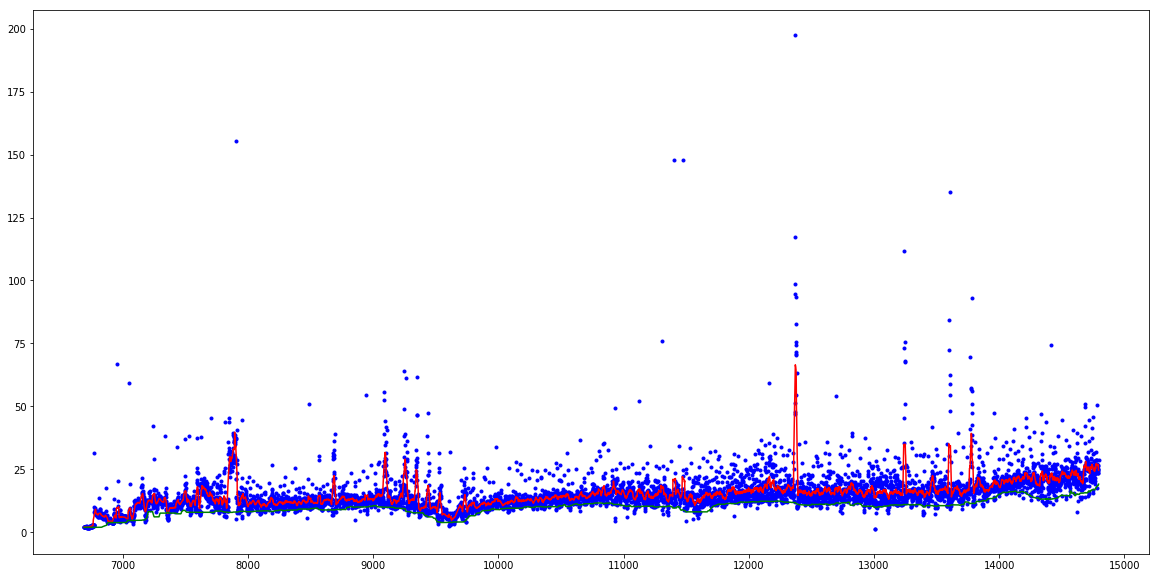

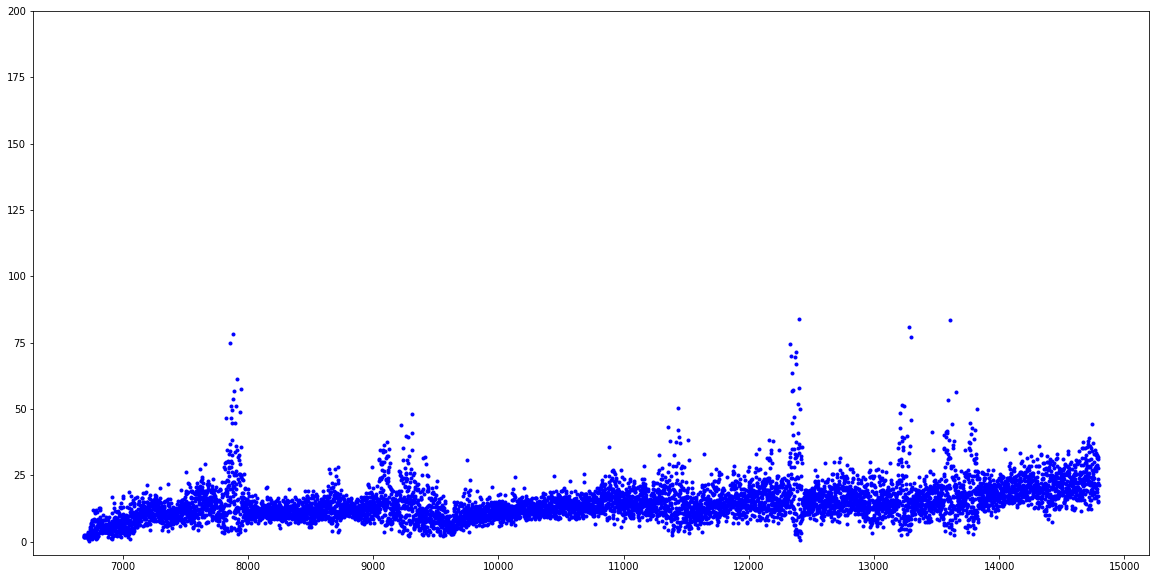

In [47]:
plt.figure(figsize=(20,10))
plt.plot(X, data, '.', color = 'b', label = 'Data')
plt.plot(X, means, color = 'r', label = 'Data')
plt.plot(X, mins, color = 'g', label = 'Data')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(X, synth_data, '.', color = 'b', label = 'Data')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,-5,200))
plt.show()

In [50]:
# k, theta = fit_gamma_ClE(transformed_data)
k, theta = fit_gamma_along_curve(transformed_data, window = 100)

print(k)

synth_data = np.random.gamma(.5*k, theta, len(data))
plt.hist(synth_data, bins = range(int(math.floor(df['N'].min())),int(math.floor(df['N'].max())),2))
plt.show()

scale_synth = np.empty((len(data)))
for i in range(len(data)):
    scale_factor = means[i]/means[0]
    scale_synth[i] = synth_data[i]*scale_factor + mins[i]
    
scale_synth = np.array([max(synth_data[i] * means[i]/means[0] + mins[i] + np.random.normal(0,1), 0) for i in range(len(synth_data))])

plt.hist(data, bins = range(int(math.floor(df['N'].min())),int(math.floor(df['N'].max())),2))
plt.show()

plt.hist(scale_synth, bins = range(int(math.floor(df['N'].min())),int(math.floor(df['N'].max())),2))
plt.show()
    

ValueError: too many values to unpack (expected 2)

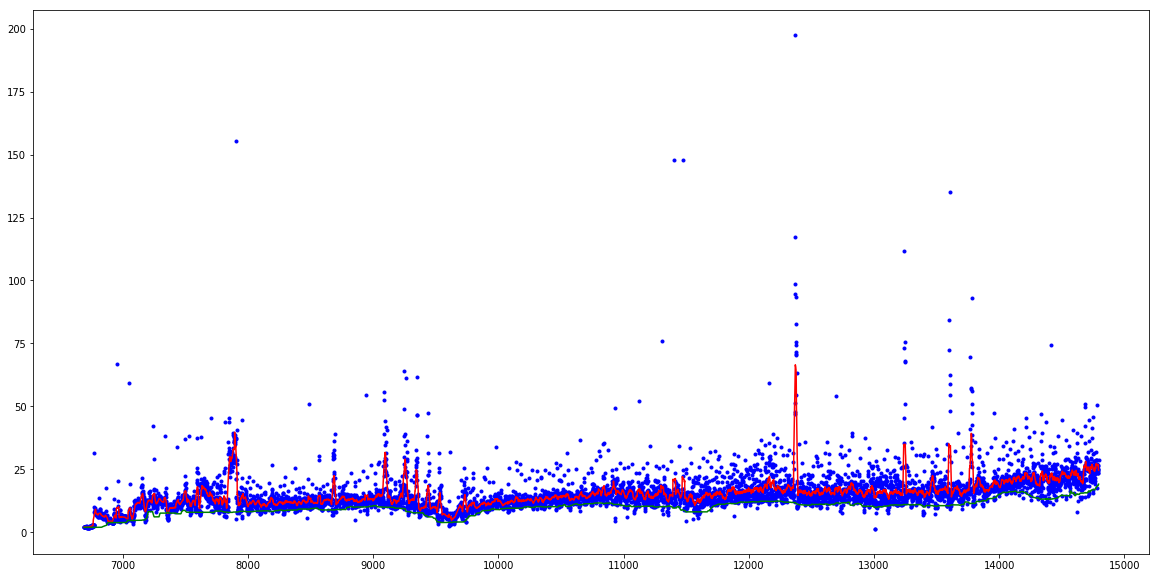

NameError: name 'scale_synth' is not defined

<Figure size 1440x720 with 0 Axes>

In [46]:
plt.figure(figsize=(20,10))
plt.plot(X, data, '.', color = 'b', label = 'Data')
plt.plot(X, means, color = 'r', label = 'Data')
plt.plot(X, mins, color = 'g', label = 'Data')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(X, scale_synth, '.', color = 'b', label = 'Data')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,-5,200))
plt.show()

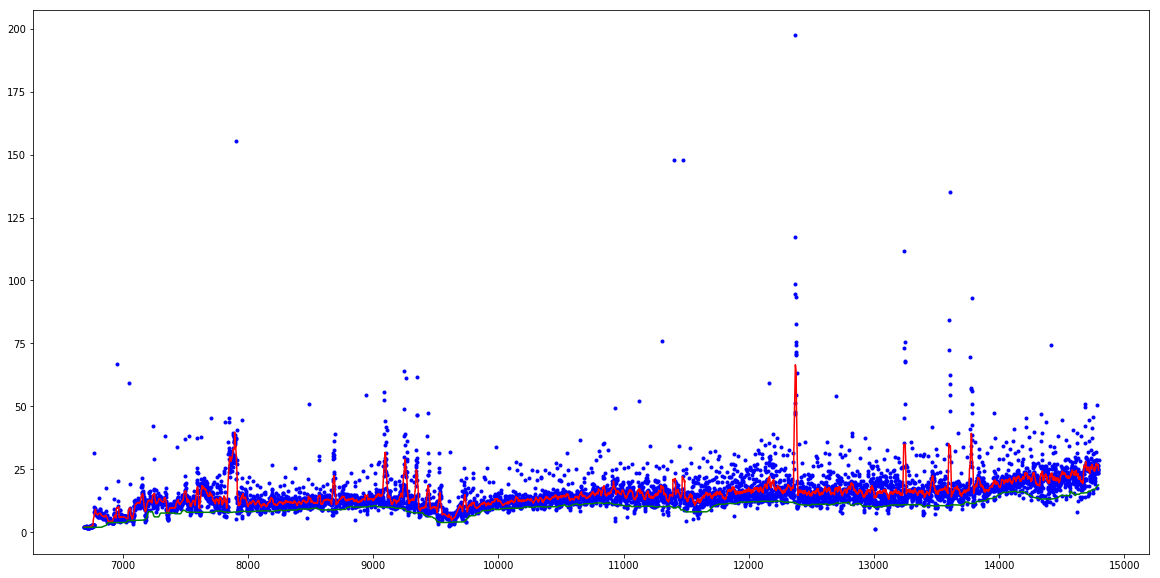

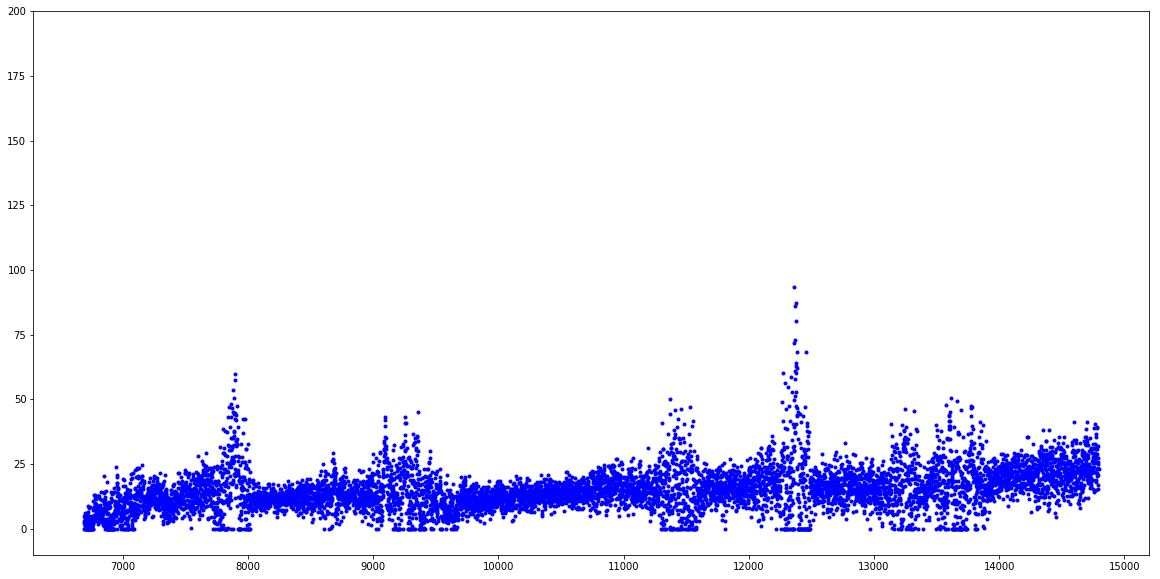

In [250]:
traveling_normal = np.array([max(np.random.normal(means[i], std_devs[i]), 0) for i in range(len(data))])

plt.figure(figsize=(20,10))
plt.plot(X, data, '.', color = 'b', label = 'Data')
plt.plot(X, means, color = 'r', label = 'Data')
plt.plot(X, mins, color = 'g', label = 'Data')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(X, traveling_normal, '.', color = 'b', label = 'Data')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,-10,200))
plt.show()

In [64]:
a = np.empty((3))
a[:] = np.nan
b = np.array([4,5])
d = np.concatenate((a,b,a), axis = 0)
d

array([nan, nan, nan,  4.,  5., nan, nan, nan])

In [68]:
half_window = 3
index = 3
d[index-half_window:index+half_window+1][~np.isnan(d[index-half_window:index+half_window+1])]

array([4., 5.])